### Якубов Вячеслав Юсупович.
#### ДЗ1

### Импорт всех необходимых библиотек

In [2]:
import os

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from torchvision.models import vgg16, inception_v3
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image

d:\mlp\machinelearning\venv\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\mlp\MachineLearning\venv\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
import pandas as pd

### Инициализация претренированной сети vgg 16 и изменение последнего слоя

In [4]:
model = vgg16(pretrained=True, progress=False)

In [5]:
model = inception_v3(pretrained=True)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(2048, 1)
model = model.to(device)

In [7]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

### Ресайз, нормализация и аугументация

In [8]:
my_transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(299),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
        transforms.RandomRotation((-10, 10)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomCrop(size=299//2),
        transforms.Resize(299),

    ]
)
my_transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(299),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))
    ]
)

### Чтение файлов в датасет и применения трансформаций

In [9]:
train_dataset = ImageFolder(root='plates/train', transform=my_transform_train)
test_dataset = ImageFolder(root='plates/train', transform=my_transform_test)

### Объявление даталоадеров

In [10]:
batch_size = 3000
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [11]:
num_epochs = 20
lr = 1e-4
optimizer = Adam(model.parameters(), lr=lr)

In [12]:
### Используем скедулер для уменьшения лернинг рейта
scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=10000, threshold=1e-3)

### Объявление loss функции

In [13]:
def loss_function(preds, true):
    loss = nn.BCEWithLogitsLoss()
    return loss(preds, true)

In [14]:
all_train_losses = []
all_test_losses = []

### Обучение и визуализация процесса обучения

loss train 0
loss test 0


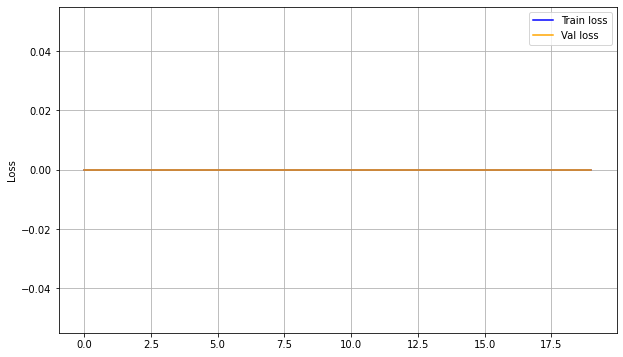

In [333]:
for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    model.train(True)
    print(f'epoch_number is {epoch}. Train')
    for (X, y) in tqdm(train_dataloader):
        model.zero_grad()
        X = X.to(device)
        y = y.to(device)
        preds = model.forward(X)
        loss = loss_function(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()/(len(train_dataloader))
    model.train(False)
    model.eval()
    print(f'epoch_number is {epoch}. Test')
    for (X, y) in tqdm(test_dataloader):
        X = X.to(device)
        y = y.to(device)
        preds = model.forward(X)
        loss = loss_function(preds, y)
        test_loss += loss.detach().item()/(len(test_dataloader))
    # scheduler.step(test_loss)
    clear_output()
    all_train_losses.append(train_loss)
    all_test_losses.append(test_loss)
    print('loss train', train_loss)
    print('loss test', test_loss)
    plt.figure(figsize = (10, 6))
    plt.plot(all_train_losses, label = 'Train loss', color = 'blue')
    plt.plot(all_test_losses, label = 'Val loss', color = 'orange')
    plt.legend()
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

In [334]:
### Получим результаты
import os

In [17]:
names = os.listdir('plates/test')

In [336]:
image = Image.open('plates/test/'+i)
image_np =  np.array(image)
pred = model.forward(my_transform_train(image_np).to(device).unsqueeze(0)).cpu().detach()

In [337]:
torch.nn.Sigmoid()(pred).item()>0.5

True

In [18]:
names = [x for x in names if '.jpg' in x]

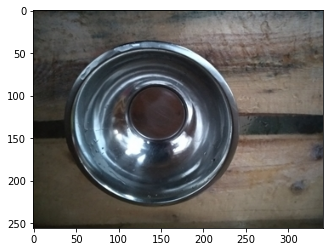

In [339]:
res = []
for i in names:
    image = Image.open('plates/test/'+i)
    image_np =  np.array(image)
    pred = model.forward(my_transform_train(image_np).to(device).unsqueeze(0)).cpu().detach()

    res.append('cleaned' if torch.nn.Sigmoid()(pred).item()>0.5 else 'dirty')
    plt.imshow(image)

ValueError: invalid literal for int() with base 10: ''

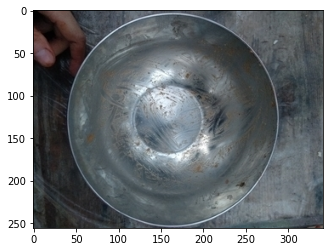

In [21]:
rrr = []
for i in names:
    image = Image.open('plates/test/'+i)
    plt.imshow(image)
    r = int(input())
    rrr.append(r)

In [340]:
res

['cleaned',
 'cleaned',
 'cleaned',
 'cleaned',
 'dirty',
 'cleaned',
 'cleaned',
 'dirty',
 'dirty',
 'cleaned',
 'cleaned',
 'cleaned',
 'cleaned',
 'dirty',
 'cleaned',
 'dirty',
 'dirty',
 'dirty',
 'dirty',
 'cleaned',
 'cleaned',
 'cleaned',
 'cleaned',
 'cleaned',
 'cleaned',
 'cleaned',
 'cleaned',
 'cleaned',
 'dirty',
 'dirty',
 'cleaned',
 'dirty',
 'dirty',
 'dirty',
 'dirty',
 'dirty',
 'dirty',
 'cleaned',
 'cleaned',
 'dirty',
 'cleaned',
 'dirty',
 'cleaned',
 'cleaned',
 'cleaned',
 'dirty',
 'cleaned',
 'cleaned',
 'cleaned',
 'cleaned',
 'cleaned',
 'dirty',
 'dirty',
 'cleaned',
 'dirty',
 'dirty',
 'cleaned',
 'dirty',
 'cleaned',
 'cleaned',
 'cleaned',
 'cleaned',
 'cleaned',
 'cleaned',
 'dirty',
 'cleaned',
 'cleaned',
 'cleaned',
 'cleaned',
 'dirty',
 'dirty',
 'cleaned',
 'cleaned',
 'cleaned',
 'dirty',
 'cleaned',
 'dirty',
 'dirty',
 'dirty',
 'cleaned',
 'dirty',
 'cleaned',
 'dirty',
 'cleaned',
 'dirty',
 'dirty',
 'dirty',
 'cleaned',
 'cleaned',
 'di

In [341]:
subm = pd.read_csv('submission.csv', converters={'id': str})

In [342]:
subm

,id,label
0,0000,dirty
1,0001,dirty
2,0002,dirty
3,0003,dirty
4,0004,dirty
...,...,...
739,0739,cleaned
740,0740,dirty
741,0741,cleaned
742,0742,dirty


In [343]:
(subm.label==res).mean()

0.4959677419354839

In [299]:
subm.label = res

In [99]:
subm.to_csv('test.csv', index=False)

In [33]:
pred

array([0.21559978, 0.40029624], dtype=float32)

In [35]:
'cleaned' if np.argmax(pred) else 'dirty'

'cleaned'

### Вывод метрик модели

In [13]:
final_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [14]:
preds = []
real = []
for x, y in final_dataloader:
    preds.append(model.forward(x.to(device)).detach().cpu().numpy())
    real.append(y.numpy())

RuntimeError: stack expects each tensor to be equal size, but got [3, 64, 85] at entry 0 and [3, 85, 64] at entry 6

In [30]:
final_preds = np.concatenate(preds).argmax(axis=1)
real = np.concatenate(real)

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       500
           1       0.95      0.95      0.95       500
           2       0.89      0.93      0.91       500

    accuracy                           0.92      1500
   macro avg       0.92      0.92      0.92      1500
weighted avg       0.92      0.92      0.92      1500



In [ ]:
print(classification_report(real, final_preds))

### Сохранение модели

In [ ]:
torch.save(model.state_dict(), 'model.pth')

### Предсказание на тесте ( вообще функция подойдет для любой картинки, до нее нужно лишь указать путь)

In [65]:
dict_names = {
    0: 'Кошка',
    1: 'Собака',
    2: 'Дикая'
}

In [77]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [84]:
def predict_by_path(path):
    image = Image.open(path)
    image_np =  np.array(image)
    pred = model.forward(my_transform_train(image_np).to(device).unsqueeze(0)).cpu().detach().numpy()[0]
    plt.imshow(image)
    res = np.argmax(pred)
    print(dict_names[res])

Кошка


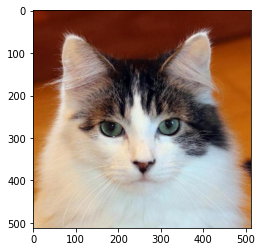

In [85]:
predict_by_path('data/val/cat/flickr_cat_000008.jpg')

Собака


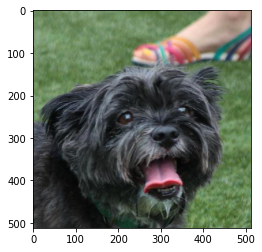

In [86]:
predict_by_path('data/val/dog/flickr_dog_000060.jpg')

Дикая


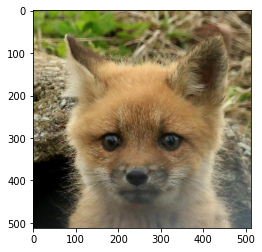

In [89]:
predict_by_path('data/val/wild/flickr_wild_000012.jpg')